# Questions:
- What does it mean to split a dataset into regressors and target variable?
    * The target variable is the variable you're trying to predict (sales). Regressor variables are the variables on which you base your prediction (all the columns that are not called sales)

- please expand on the meaning of dummy variable, how do the specific lines of code do
    * A dummy variable is one that takes only the value 0 or 1 to indicate the absence or presence of some categorical effect that may be expected to shift the outcome. Dummy variables are used because models can't automatically work with categorical variables. For example if you have a variable that describes the month we're in (it can take values 'Jan', 'Feb' and so on), it must be converted to an array of zeros and ones of length equal to the number of categorical options.
    * E.g. ['Jan'] becomes [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    *      ['Feb'] becomes [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    * Note that only one dummy variable takes value = 1, all the other are zeros.   


- If I understood well, we have 5 years of data (one data point per day), repeated for every store and repeated for every item. 
    * Correct.

- In Ln34 you define store_1_item1_time_series. What is it? Are you isolating an array of just the 5 years of data for just store 1 and item 1? Are the two graphs below the sales (on the y axis)for that shop and item?
    * Correct. The line of code:
    * store_1_item_1_time_series = data[data['store'].eq(1) & data['item'].eq(1)]['sales']
    
    * should be read as:
    * "Take the variable data, filter it by taking all observations in which the column store takes value 1, and the variable the column item takes value 1"

- Do the predictions/graphs in line 42( and the correspondent ones for Random Forest, Arima , etc... refer to store 1-item 1, or an average of sales in all stores and items?
    * The first two graphs correspond to store1 item1, but whenever I call the "model_report" function, I'm plotting the best and worst predicted series. I also plot the histograms and scatterplots for all the series together.
  

- I haven’t understood well the function in ln 45. If all the graphs and the RMSE in lines 42 to 44 were only for store 1 -item 1, does line 45 iterate all those operations for 499 more times( the combinations of the remaining stores and items)? So what you’re doing is, for store 1-item 1 you show a large set of results ( histograms, RMSE, graph of predictions), and then for the whole dataset you define a more limited set of operations (defined in line 45) which only store the predicted values, avoiding to do the graphs/histograms every single time. You show then histograms and the RMSE for the whole dataset. If that’s correct, correct, are the errors for store1-item 1 in Ln 43 and for the whole dataset in Ln 51 calculated in the same way for the histograms? If so, why do you write separately the code twice instead of using a single function?
    Don't worry about this part for now, I will make it more understandable later.

- Is 11.8s the time it takes to complete all the operations in lines 45-46? Where is this time calculation in the code?
    * Whenever I write "%%time", jupyter understands that it should time all the operations within a certain cell.
    
- Is Ln 48 the inverse operation of group by, just because we want to show the list of predictions in the same format of the original dataframe?
    * I'm not sure what you mean by inverse of group by. If you are referring to the merge operation, I just use it to have the forecast and the sales series side by side.
    
- In Ln 91, is a “series” the five years of data for each store-item? Where in the code did we calculate the RMSE for the 500 series? Are we concluding that store 6-item 1 is the one series out of 500 that gave the most accurate predictions with linear regression?
    * The RMSE of the whole dataset is calculated inside model_report() line 10.
    * The RMSE of the individual time series is calculated inside plot_best_worst_series(), in line 1 & 2: i first group by store and item, then calculate the standard deviation (.std()) of the 'error' column. The standard deviation of the error is just the RMSE. I should have been a bit more explicit maybe, but it was more convenient to structure the code that way.

- For Arima and Random forest you used the function’Model report’ which ranks the dataset for the best and worst day among all days/stores/items instead of just stating the best and worst store-item like in linear regression. Is there a particular reason for this change in you are ranking?
    * The model report displays the best and worst predicted series. Different models usually detect different patterns in the data, so their performance in predicting a particular series or observation may vary. For example if you have a really noisy series with few values, a moving average can be a better predictor than a very deep neural network. But if a series has consistent patterns and lots of data points, the neural network will most likely outperform the moving average model.

# Instructions:
* Download the repository
* Install all packages from the command line with pip, example: pip install pandas
* Launch jupyter notebook from the command line
* Open the desired notebook
* ???
* Profit

* For any issues don't hesitate to contact me

In [147]:
# Core Libraries
import pandas as pd  # For creating and manipulating dataframes
import numpy as np  # For fast calculations
# Models
import statsmodels.api as sm  # For linear regression
import statsmodels.tsa as ts  # For time series analyses
from sklearn.ensemble import RandomForestRegressor  # Random Forest algorithm
from sklearn.neural_network import MLPRegressor # sklearn implementation of MLP neural network
import lightgbm as lgb  # Great gradient boosted trees algorithm written by microsoft
# Deep learning
import torch  # PyTorch library
import torch.nn as nn  # Module for creating neural networks
import torch.nn.functional as F  #
import torch.optim as opt

import os
# Plotting
import matplotlib.pyplot as plt
plt.style.use('bmh')  # With this line you change the style of the plots so they're prettier
# The line below this comment allows you to view plots directly in jupyter
%matplotlib inline

# Utils
import warnings
warnings.filterwarnings('ignore')  # Remove annoying warnings

In [148]:
plt.rcParams["figure.figsize"] = (16, 9) # Makes plots larger and in 16:9

In [149]:
# Source: https://www.kaggle.com/c/demand-forecasting-kernels-only/data

data = pd.read_csv('Data/train.csv', parse_dates=['date'], index_col='date')

In [150]:
# The input file contains data for sales in 10 stores and 50 different items
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


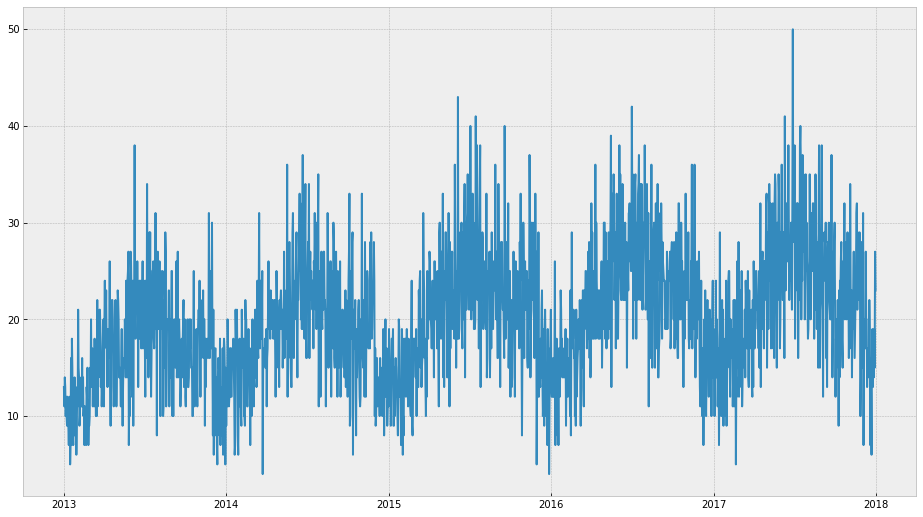

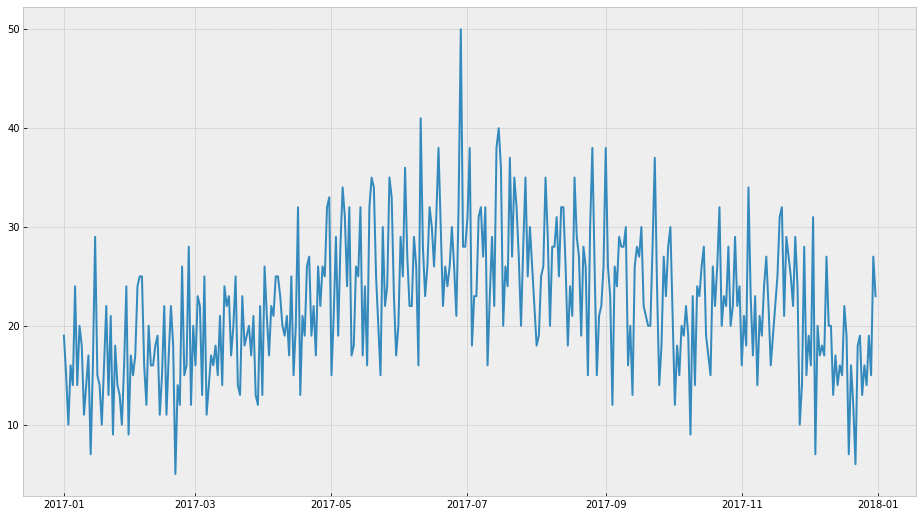

In [151]:
# Let's see what a time series looks like using matplotlib
store_1_item_1_time_series = data[data['store'].eq(1) & data['item'].eq(1)]['sales']
plt.plot(store_1_item_1_time_series)
plt.show()

# Last year
plt.plot(store_1_item_1_time_series.iloc[-365:])
plt.show()

# Clear seasonality patterns are evident in the graph, with peaks during the summer months
# The series is also characterized by a positive growth trend

,store,item,sales,day of week,day name
date,,,,,
2013-01-01,1,1,13,1,Tuesday
2013-01-02,1,1,11,2,Wednesday
2013-01-03,1,1,14,3,Thursday
2013-01-04,1,1,13,4,Friday
2013-01-05,1,1,10,5,Saturday


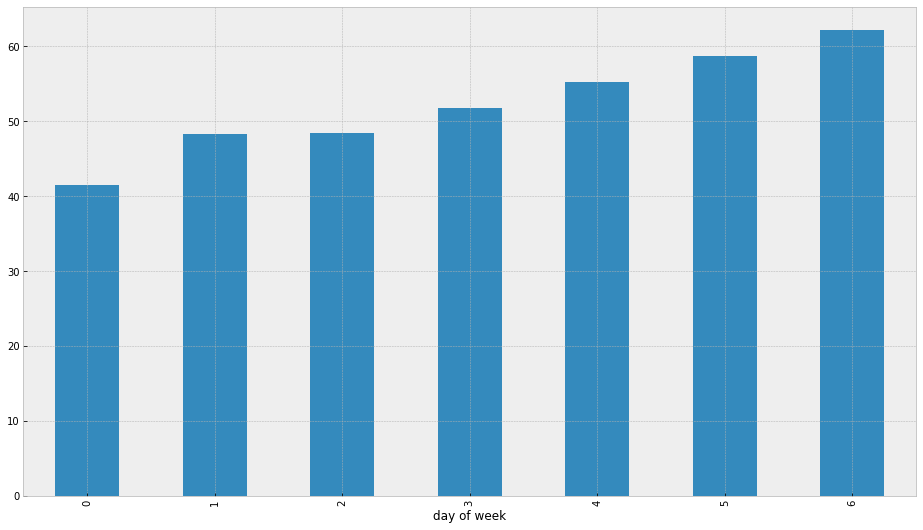

In [152]:
# Check whether weekly seasonality exists
data['day of week'] = data.index.dayofweek # add day of week column
data['day name'] = data.index.day_name()
display(data.head())
data.groupby('day of week')['sales'].mean().plot(kind='bar')
plt.show()
# Sales seem to be slighly larger during the weekends

# Drop the time period columns columns so we can later work on the original dataframe
data = data.drop(['day of week', 'day name'], axis=1) 

# Linear Regression

In [153]:
# In order to perform a linear regression on the seasonal components, we must first convert the data
# transforming categorical variables to dummy variables

def preprocess_series(series):
    data = pd.DataFrame()
    data['sales'] = series
    data['month'] = series.index.month # For monthly seasonality
    data['day_of_week'] = series.index.dayofweek # For weekly seasonality
    data['year'] = series.index.year # To account for trend
    # Convert seasonal variables to dummies
    data = pd.get_dummies(data, columns=['month', 'day_of_week'], drop_first=True)
    return data

In [154]:
# Check the output of the function
preprocessed_series = preprocess_series(store_1_item_1_time_series)
preprocessed_series.head()

,sales,year,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,
2013-01-01,13,2013,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2013-01-02,11,2013,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2013-01-03,14,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-04,13,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2013-01-05,10,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [155]:
# I'll now define some data manipulation functions that will be useful during training

# In general, we will want to train the algorithm on roughly 70-90% of the data, and then evaluate
# the performance on the rest. We will take the last year of data to evaluate the algorithm performance

def get_training_and_test_data(data):
    train_data_index = (data.index < '2017-01-01')
    train_data = data.loc[train_data_index] 
    test_data = data.loc[~train_data_index] # Take the complement of the train set for the test set
    return train_data, test_data

In [156]:
# This function simply splits the datasets, returning one table with regressors, and a series with
# the target variable

def split_regressors_and_target_variables(data, target_variable='sales'):
    regressors = data.drop(target_variable, axis=1)
    target = data[target_variable]
    return regressors, target

# Linear Regression - example on one series 

In [157]:
# Now we're ready to train our first model!

train_data, test_data = get_training_and_test_data(preprocessed_series)
X_train, y_train = split_regressors_and_target_variables(train_data)
X_test, y_test = split_regressors_and_target_variables(test_data)

In [158]:
# Instantiate an ordinary least squares regression model
model = sm.OLS(y_train, X_train)
# Train the model
model = model.fit()
# Now you can get the predictions on the test set
predictions = model.predict(X_test)

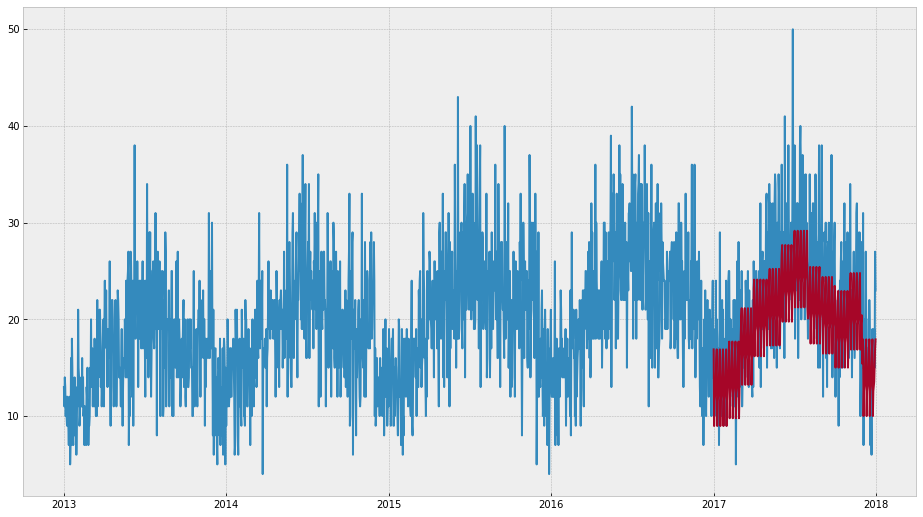

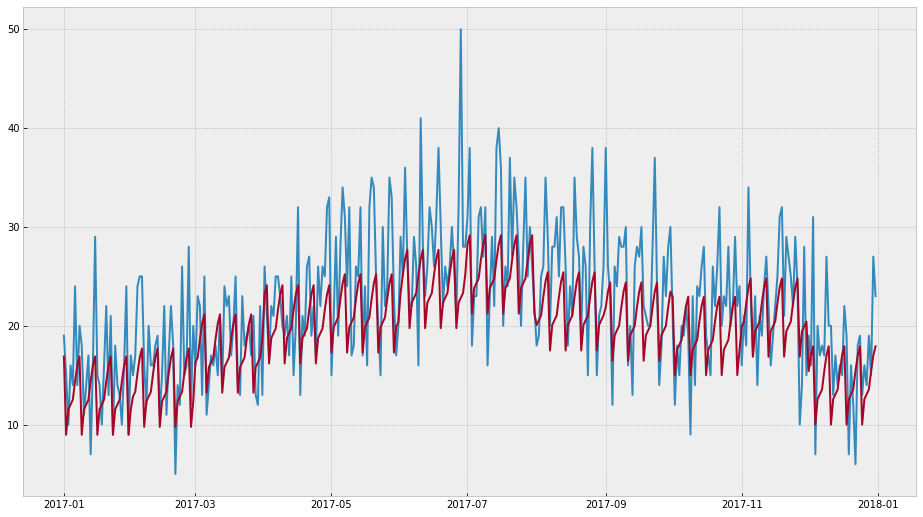

In [159]:
# Let's check how our model did on this example series with matplotlib
plt.plot(store_1_item_1_time_series)
plt.plot(predictions)
plt.show()

plt.plot(y_test)
plt.plot(predictions)
plt.show()

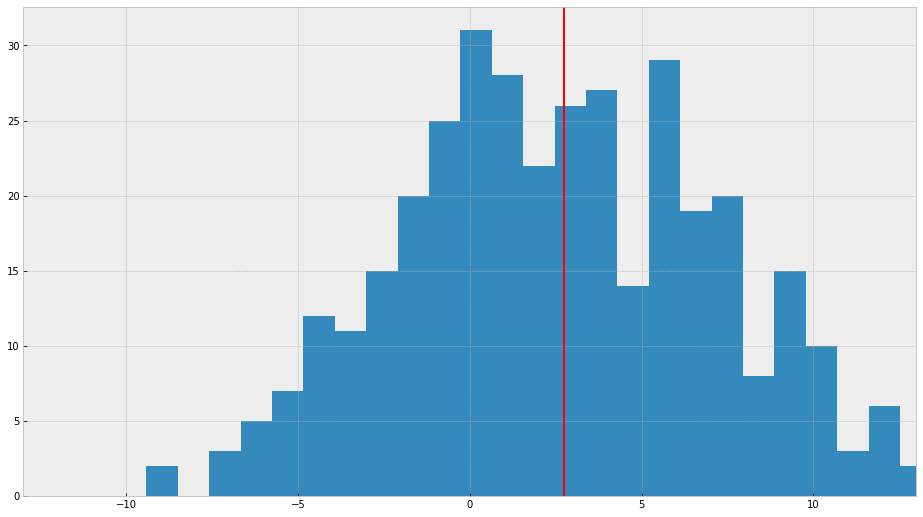

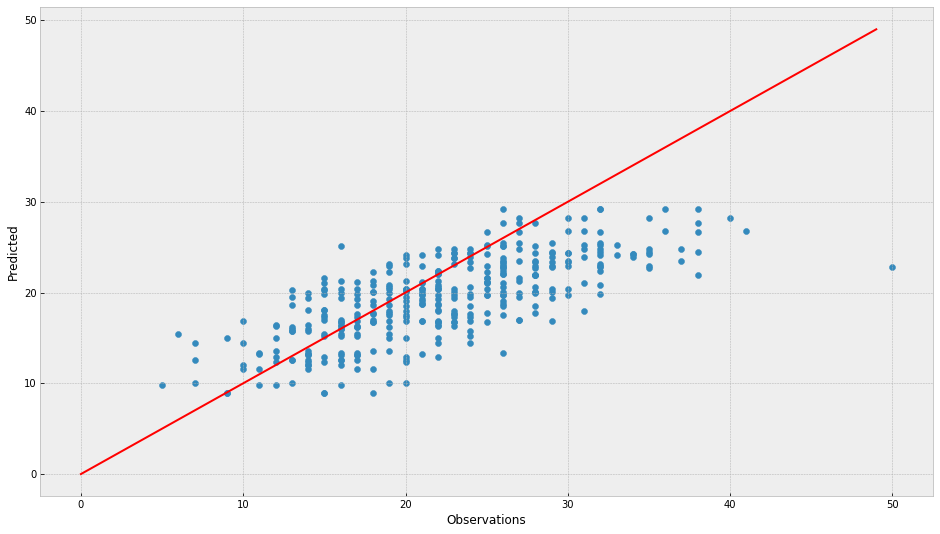

In [160]:
# It seems that in this particular case the model underestimated demand
# Let's check the error distribution
errors = y_test - predictions
mean_error = errors.mean()
plt.hist(errors, bins=40)
plt.xlim(-13, 13)
plt.axvline(mean_error, c='red')
plt.show()

# Let's see how predictions and observations are correlated
plt.scatter(y_test, predictions)
plt.xlabel('Observations')
plt.ylabel('Predicted')
plt.plot(list(range(50)), list(range(50)), color='red')
plt.show()

In [161]:
# We should calculate the Root Mean Squared Error (RMSE), in order to compare the performances 
# of each algorithm
def rmse(observations, predictions):
    return np.sqrt(np.square(observations - predictions).mean())

print(f'The RMSE was {rmse(y_test, predictions)}')

The RMSE was 5.536602770478944


# Linear Regression on the whole dataset

In [162]:
# Good, now that we established the workflow for a single series, we should apply the algorithm to
# the whole dataset. We will be iterating through stores and items, performing a forecast 
# for each time series.
# We can take advantage of the pandas library group by function, but first let's wrap the whole
# training and prediction procedure in a single function:

def perform_linear_regression_forecast_on_series(series):
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = sm.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    return predictions

In [17]:
%%time
# Let's apply the function to the dataset grouped by store and item
# Let's also time the algorithm, so we can later on evaluate how fast the algorithms were

result = (data.groupby(['store', 'item'])['sales']
              .apply(perform_linear_regression_forecast_on_series)
              .to_frame()
              .rename(columns={'sales': 'predicted'}))

Wall time: 28.8 s


In [18]:
result

predicted
store item date                 
1     1    2017-01-01  16.896689
           2017-01-02   8.971285
           2017-01-03  11.550655
           2017-01-04  12.050509
           2017-01-05  12.524238
...                          ...
10    50   2017-12-27  49.644798
           2017-12-28  54.296062
           2017-12-29  58.733136
           2017-12-30  63.144906
           2017-12-31  67.818274

[182500 rows x 1 columns]

In [19]:
# Merge with the original dataframe
forecast = data.merge(result, on=['date', 'store', 'item'])
forecast.head(10)

,store,item,sales,predicted
date,,,,
2017-01-01,1,1,19,16.896689
2017-01-02,1,1,15,8.971285
2017-01-03,1,1,10,11.550655
2017-01-04,1,1,16,12.050509
2017-01-05,1,1,14,12.524238
2017-01-06,1,1,24,14.390774
2017-01-07,1,1,14,15.972613
2017-01-08,1,1,20,16.896689
2017-01-09,1,1,18,8.971285


In [20]:
# Save the result in the /Results folder
forecast.to_csv('Results/Linear_Regression.csv')

In [21]:
# Let's evaluate the performance of the Linear Regression model over the whole test dataset
print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')

The overall RMSE was 12.076787816661742
The mean error was 8.138578542248561


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-02,2,15,231,161.113744,69.886256,69.886256
2017-07-05,8,15,193,126.800335,66.199665,66.199665
2017-08-20,2,18,201,136.993416,64.006584,64.006584
2017-07-16,9,28,195,131.651272,63.348728,63.348728
2017-07-16,9,18,187,124.625851,62.374149,62.374149
2017-06-02,8,15,192,129.896887,62.103113,62.103113
2017-06-17,3,13,185,123.558503,61.441497,61.441497
2017-07-01,8,28,204,145.974912,58.025088,58.025088
2017-08-25,2,10,165,107.133457,57.866543,57.866543


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-01-10,8,1,15,14.999514,0.000486,0.000486
2017-12-05,5,14,29,28.999594,0.000406,0.000406
2017-02-09,6,22,44,43.999633,0.000367,0.000367
2017-09-01,4,16,29,28.999681,0.000319,0.000319
2017-09-08,4,16,29,28.999681,0.000319,0.000319
2017-11-03,4,38,91,91.000289,-0.000289,0.000289
2017-08-21,2,41,25,24.999751,0.000249,0.000249
2017-03-15,1,33,51,51.000236,-0.000236,0.000236
2017-03-30,2,6,65,64.999827,0.000173,0.000173


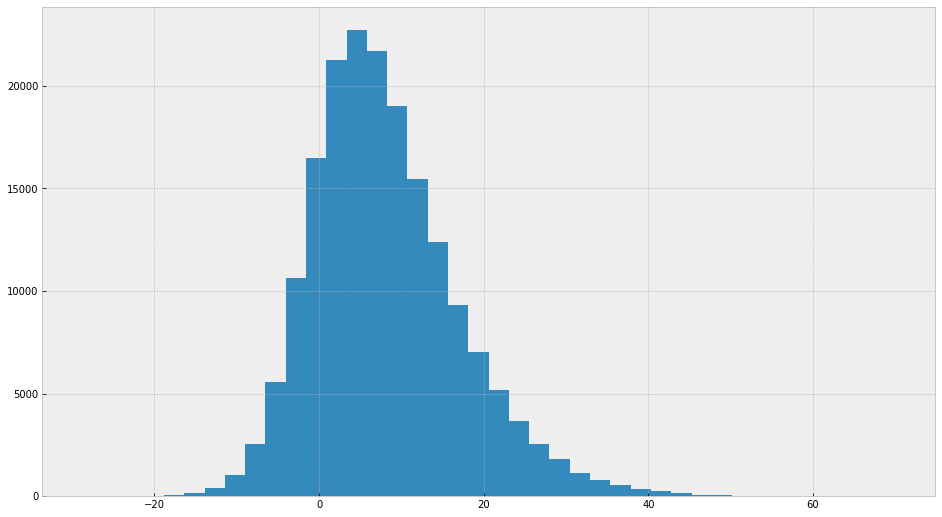

In [22]:
# It looks like the RMSE calculated over the test dataset was significantly higher than in the
# first example. It also looks like the forecast was too pessimistic, as sales tended to be higher
# than the predictions. Let's see where the algorithm was least (and most) accurate
forecast['error'] = forecast['sales'] - forecast['predicted']
forecast['absolute_error'] = np.abs(forecast['error'])
sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
display(sorted_by_abs_err.head(10))
display(sorted_by_abs_err.tail(10))

plt.hist(forecast['error'], bins=40)
plt.show()

In [163]:
# Let's define some functions to plot the best and worst predicted series

def plot_best_worst_series(forecast, n=4):
    # Sort all the series by their rmse, to find best and worst predicted
    sorted_by_error = (forecast.groupby(['store', 'item'])['error']
                           .std()
                           .reset_index()
                           .sort_values('error')
                           .rename(columns={'error': 'rmse'}))
    # Create a dictionary with the ids of the stores and items of the best/worst series
    top_predicted = sorted_by_error[['store', 'item']].head(n).to_dict(orient='records')
    bot_predicted = sorted_by_error[['store', 'item']].tail(n).to_dict(orient='records')
    # Display the series names, and plot the series
    print('Best predicted time series: ')
    display(sorted_by_error.head(n))
    plot_forecasts_from_data(forecast, top_predicted)
    print('Worst predicted time series: ')
    display(sorted_by_error.tail(n))
    plot_forecasts_from_data(forecast, bot_predicted)


def plot_forecasts_from_data(forecast, series_dicts):
    # I created this graphing function, since the commands were the same for plotting the best
    # and the worst series
    for series_info in series_dicts:
        temp = forecast[forecast['store'].eq(series_info['store']) &
                        forecast['item'].eq(series_info['item'])]
        plt.figure(figsize=(8, 6))
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.plot(temp['sales'])
        plt.plot(temp['predicted'])
        plt.legend()
        plt.show()

Best predicted time series: 


,store,item,rmse
250,6,1,3.836363
204,5,5,3.932919
303,7,4,4.089260
304,7,5,4.099541


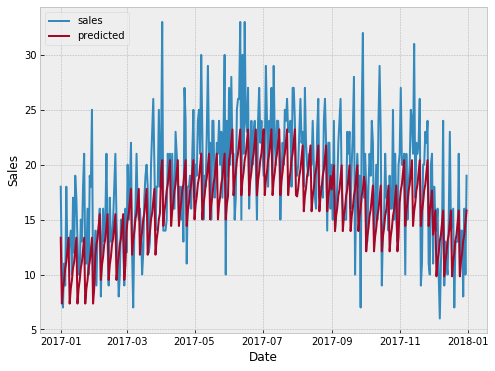

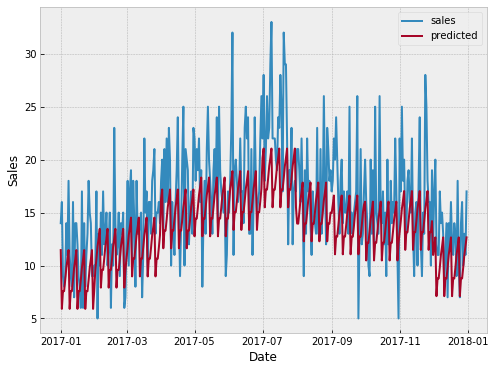

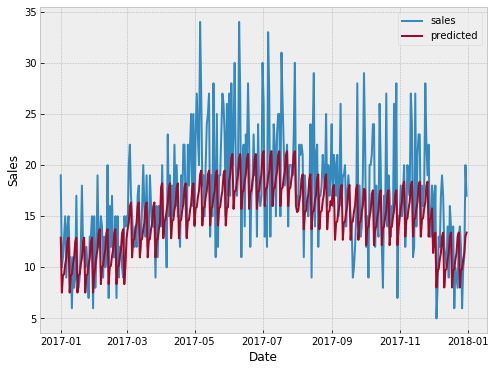

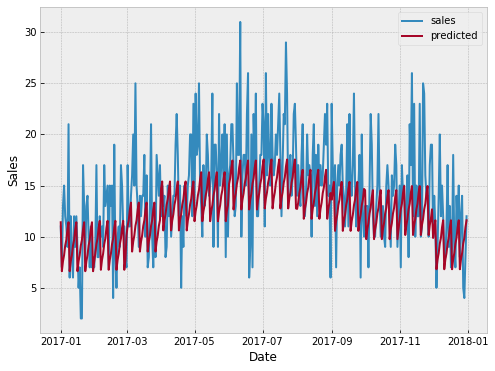

Worst predicted time series: 


,store,item,rmse
94,2,45,12.248379
77,2,28,12.305637
364,8,15,12.448777
67,2,18,12.973821


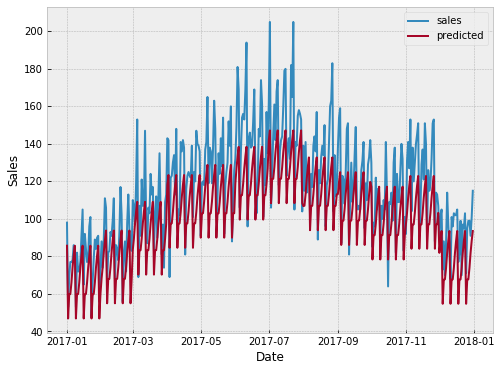

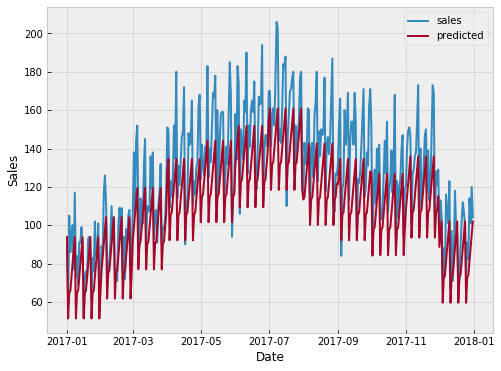

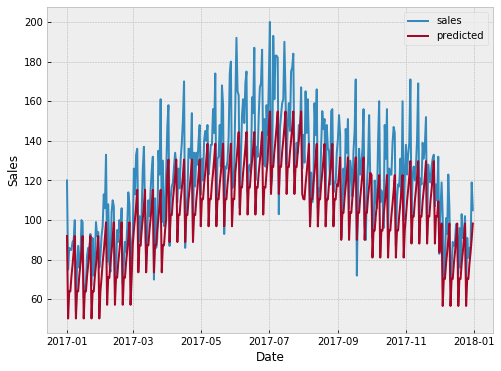

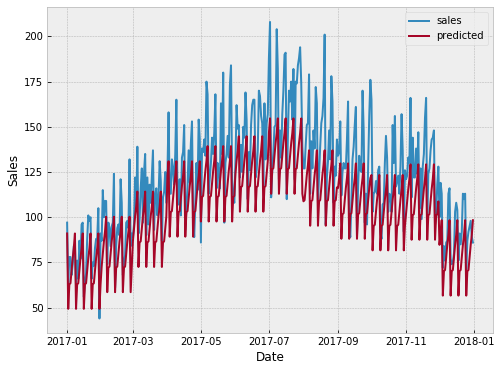

In [24]:
plot_best_worst_series(forecast)

In [164]:
# Since all of our models' outputs will be the same (date, store, item: prediction), we might 
# as well create a function to saves the results, and analyzes them.
# I also added a function for plotting errors and correlations

def plot_error_graphs(actual, predicted):
    errors = actual - predicted
    mean_error = errors.mean()
    plt.hist(errors, bins=40)
    plt.axvline(mean_error, c='red')
    plt.show()

    plt.scatter(actual, predicted)
    plt.xlabel('Observations')
    plt.ylabel('Predicted')
    line_length = actual.max()
    coordinates = list(range(line_length))
    plt.plot(x=coordinates, y=coordinates, color='red', alpha=0.5)
    plt.show()


def model_report(original_data, model_output, model_name, n_rows_to_display=10):
    forecast = original_data.merge(model_output, on=['date', 'store', 'item'])
    forecast.to_csv('Results/' + model_name + '.csv')
    forecast['error'] = forecast['sales'] - forecast['predicted']
    forecast['absolute_error'] = np.abs(forecast['error'])
    sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
    print('Most inaccurate')
    display(sorted_by_abs_err.head(n_rows_to_display))
    print('Most accurate')
    display(sorted_by_abs_err.tail(n_rows_to_display))
    print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
    print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')
    plot_error_graphs(forecast['sales'], forecast['predicted'])
    plot_best_worst_series(forecast)

# Random Forest

In [165]:
# Let's now apply the random forest regression algorithm. Luckily some of the steps to perform
# in order to apply this algorithm, are the same as for linear regression, and we can reuse some
# functions. We'll be using the same workflow as before, namely, group by, fit, forecast,
# combine results, and evaluate the model

def perform_rf_forecast_on_series(series):
    
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = RandomForestRegressor(n_estimators=100)
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test) # Prediction is a numpy.array
    predictions = pd.Series(data=predictions,
                            index=y_test.index,
                            name='sales') # Convert to a pandas series
    return predictions

# Since we are going to use this workflow many times, let's just create a function for our workflow
# So we don't have to type the same stuff over and over
def predict_all_series(data, function_to_apply):
    result = (data.groupby(['store', 'item'])['sales']
                  .apply(function_to_apply)
                  .to_frame()
                  .rename(columns={'sales': 'predicted'}))
    return result

In [27]:
%%time
rf_forecast = predict_all_series(data, perform_rf_forecast_on_series)

Wall time: 4min 8s


In [31]:
rf_forecast

predicted
store item date                 
1     1    2017-01-01  17.414349
           2017-01-02  10.495909
           2017-01-03  14.642802
           2017-01-04  13.271425
           2017-01-05  14.709925
...                          ...
10    50   2017-12-27  51.008179
           2017-12-28  59.550667
           2017-12-29  71.145012
           2017-12-30  69.949745
           2017-12-31  63.288496

[182500 rows x 1 columns]

Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-08-20,2,18,201,144.723234,56.276766,56.276766
2017-06-02,8,15,192,138.875857,53.124143,53.124143
2017-11-10,10,15,154,101.811591,52.188409,52.188409
2017-07-05,8,15,193,142.120643,50.879357,50.879357
2017-07-30,3,8,178,129.764034,48.235966,48.235966
2017-11-12,3,11,139,90.770425,48.229575,48.229575
2017-06-17,2,2,150,101.905401,48.094599,48.094599
2017-08-27,2,45,183,135.618965,47.381035,47.381035
2017-03-10,8,8,131,84.075357,46.924643,46.924643


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-08,9,47,36,35.999623,0.000377,0.000377
2017-07-29,9,47,36,35.999623,0.000377,0.000377
2017-11-10,8,42,56,55.999647,0.000353,0.000353
2017-01-31,1,19,27,26.999651,0.000349,0.000349
2017-05-06,5,36,83,83.000343,-0.000343,0.000343
2017-10-18,8,11,80,79.999721,0.000279,0.000279
2017-01-08,7,32,29,28.999766,0.000234,0.000234
2017-02-28,10,46,49,49.000159,-0.000159,0.000159
2017-06-27,3,30,57,56.999869,0.000131,0.000131


The overall RMSE was 8.849885597337554
The mean error was 2.2420686972509873


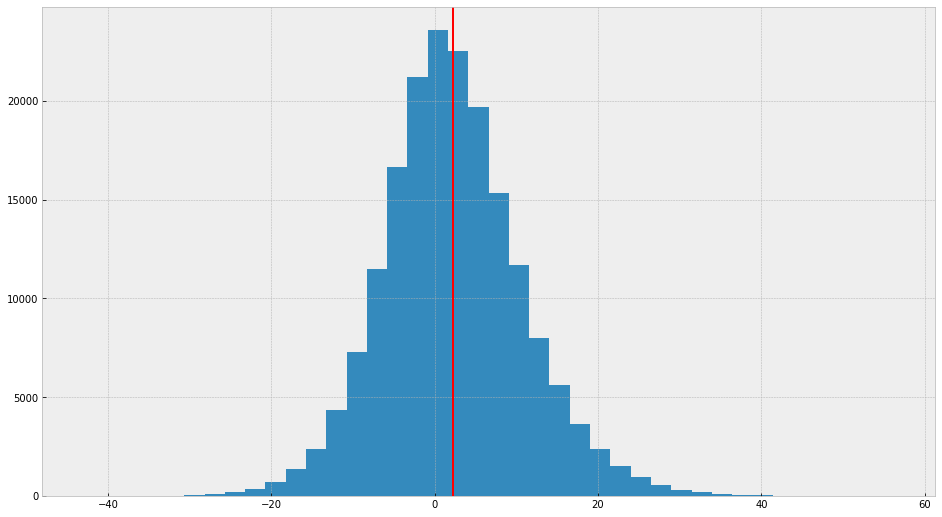

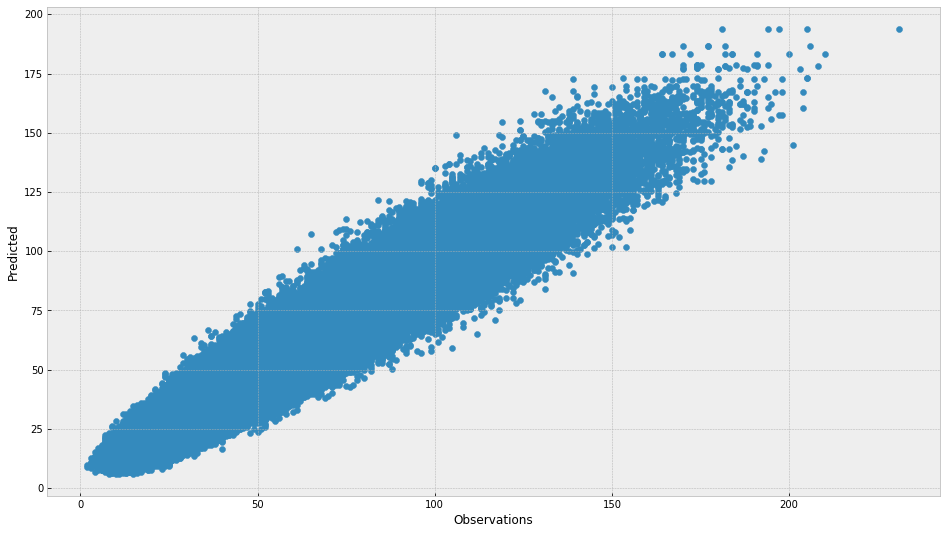

In [37]:
model_report(original_data=data,
             model_output=rf_forecast,
             model_name='RandomForest')

# ARIMA

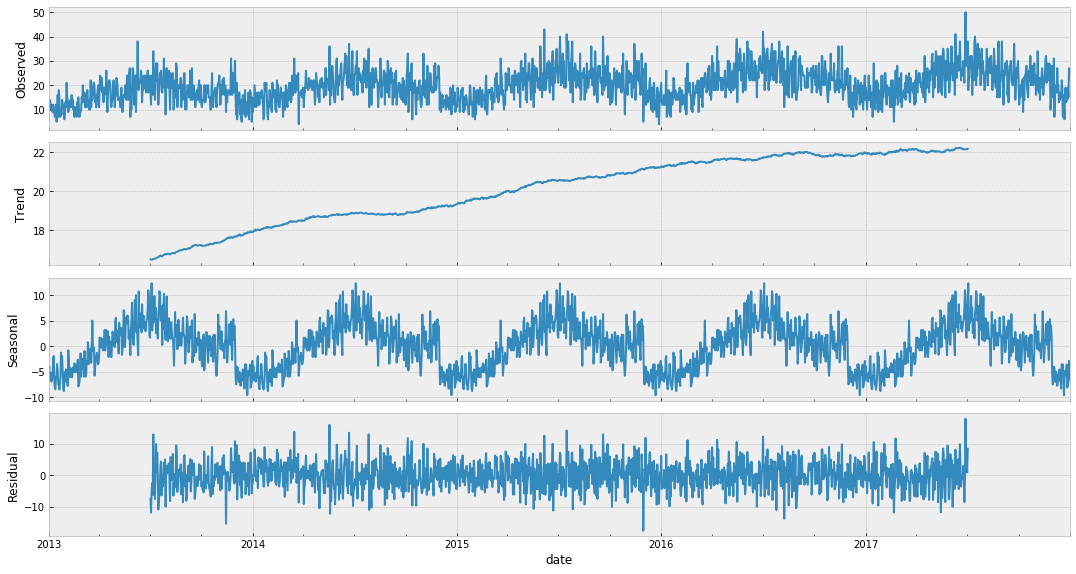

In [50]:
# First of all let's take a look at the seasonal trend decomposition of a single series
res = sm.tsa.seasonal_decompose(store_1_item_1_time_series, freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

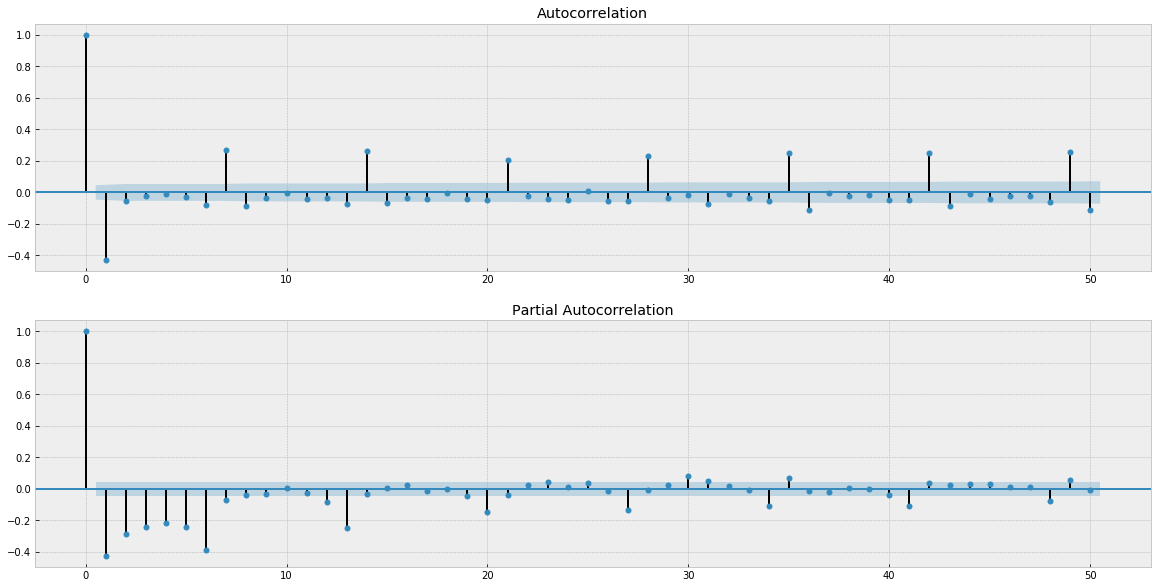

In [33]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(store_1_item_1_time_series.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(store_1_item_1_time_series.diff().dropna(), lags=50, ax=ax[1])
plt.show()

# The autocorrelation graph shows the correlation of an observation with its lagged values (from 1 to 50)
# The partial autocorrelation graph shows the correlation of the differenced series observation and its lags
# From the autocorrelation plot, a weekly seasonality is noticeable

In [129]:
store_1_item_1_time_series_lags = store_1_item_1_time_series - store_1_item_1_time_series.shift(365)

store_1_item_1_time_series_lags.index = store_1_item_1_time_series.index

arima_series = store_1_item_1_time_series.iloc[365:]
arima_lags = store_1_item_1_time_series_lags.iloc[365:]

train_series, test_series = get_training_and_test_data(arima_series)
train_lags, test_lags = get_training_and_test_data(arima_lags)

sarima = sm.tsa.statespace.SARIMAX(train_series,
                                   order=(7,0,7),
                                   exog=train_lags.values.reshape([-1, 1]),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False,
                                   simple_differencing=True,
                                   freq='D').fit()

In [134]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1096
Model:               SARIMAX(7, 0, 7)   Log Likelihood               -2850.075
Date:                Wed, 22 Jan 2020   AIC                           5732.149
Time:                        12:00:36   BIC                           5812.023
Sample:                    01-01-2014   HQIC                          5762.382
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5226      0.014     37.144      0.000       0.495       0.550
ar.L1          0.1210      0.246      0.492      0.623      -0.361       0.603
ar.L2         -0.0824      0.257     -0.320      0.749      -0.587       0.422
ar.L3          0.0282      0.249      0.113      0.910      -0.461       0.517
ar.L4          0.0306      0.227      0.135      0.893      -0.415       0.476
ar.L5         -0.0857      0.206     -0.416      0.677      -0.489       0.318
ar.L6          0.1216      0.204      0.597      0.551      -0.278       0.521
ar.L7          0.8656      0.223      3.888      0.000       0.429       1.302
ma.L1          0.0418      0.255      0.164      0.870      -0.458       0.542
ma.L2          0.2099      0.231      0.910      0.363      -0.242       0.662
ma.L3          0.1152      0.240      0.479      0.632      -0.356       0.586
ma.L4          0.1006      0.209      0.481      0.630      -0.309       0.510
ma.L5          0.2477      0.190      1.302      0.193      -0.125       0.621
ma.L6          0.0359      0.210      0.171      0.864      -0.376       0.447
ma.L7         -0.7067      0.197     -3.579      0.000      -1.094      -0.320
sigma2        11.1312      0.677     16.436      0.000       9.804      12.459
===================================================================================
Ljung-Box (Q):                       33.08   Jarque-Bera (JB):                 8.24
Prob(Q):                              0.77   Prob(JB):                         0.02
Heteroskedasticity (H):               1.31   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
predictions = sarima.predict(start=test_series.index[0],
                             end=test_series.index[-1],
                             exog=test_lags.values.reshape([-1, 1]))

plt.plot(test_series)
plt.plot(predictions)

In [307]:
# Now let's wrap everything into a function
def add_lags(data, column='sales', lags=[365]):
    # This function adds lagged observations of a column (default is sales) to a dataframe
    for lag in lags:
        data[f'lag_{lag}'] = data[column].shift(lag)
    data = data.dropna()
    return data

def perform_sarima_forecast_on_series(series):
    
    series = preprocess_series(series)
    series = add_lags(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    

    sarima = sm.tsa.statespace.SARIMAX(y_train,
                                       order=(7,1,7),
                                       exog=X_train,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,
                                       freq='D').fit()
    predictions = sarima.predict(start=test_series.index[0],
                                 end=test_series.index[-1],
                                 exog=X_test)
    predictions = np.maximum(0, predictions)
    return predictions

In [ ]:
%%time
sar_result = predict_all_series(data, perform_sarima_forecast_on_series)

In [ ]:
sar_result

In [ ]:
# Renaming the date column, because the statsmoels implementation for sarima is dumb
sar_result = (sar_result.reset_index()
                        .rename(columns={'level_2': 'date'})
                        .set_index('date'))

Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-12-31,3,12,89,4.470107e+08,-4.470106e+08,4.470106e+08
2017-12-30,3,12,66,-4.246286e+08,4.246287e+08,4.246287e+08
2017-12-29,3,12,91,4.033675e+08,-4.033674e+08,4.033674e+08
2017-12-28,3,12,64,-3.831706e+08,3.831707e+08,3.831707e+08
2017-12-27,3,12,72,3.639852e+08,-3.639852e+08,3.639852e+08
2017-12-26,3,12,54,-3.457603e+08,3.457603e+08,3.457603e+08
2017-12-25,3,12,57,3.284480e+08,-3.284480e+08,3.284480e+08
2017-12-24,3,12,82,-3.120025e+08,3.120025e+08,3.120025e+08
2017-12-23,3,12,93,2.963805e+08,-2.963804e+08,2.963804e+08


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-10-01,4,32,65,64.998282,0.001718,0.001718
2017-01-27,7,7,34,33.998292,0.001708,0.001708
2017-01-21,3,32,49,49.001375,-0.001375,0.001375
2017-01-19,5,11,56,56.001228,-0.001228,0.001228
2017-02-23,10,1,24,23.999531,0.000469,0.000469
2017-03-13,1,23,20,20.000437,-0.000437,0.000437
2017-02-12,4,41,23,23.000410,-0.000410,0.000410
2017-01-28,6,14,47,46.999765,0.000235,0.000235
2017-03-01,7,1,15,14.999776,0.000224,0.000224


The overall RMSE was 3348782.8861770728
The mean error was -1239.3876224596395


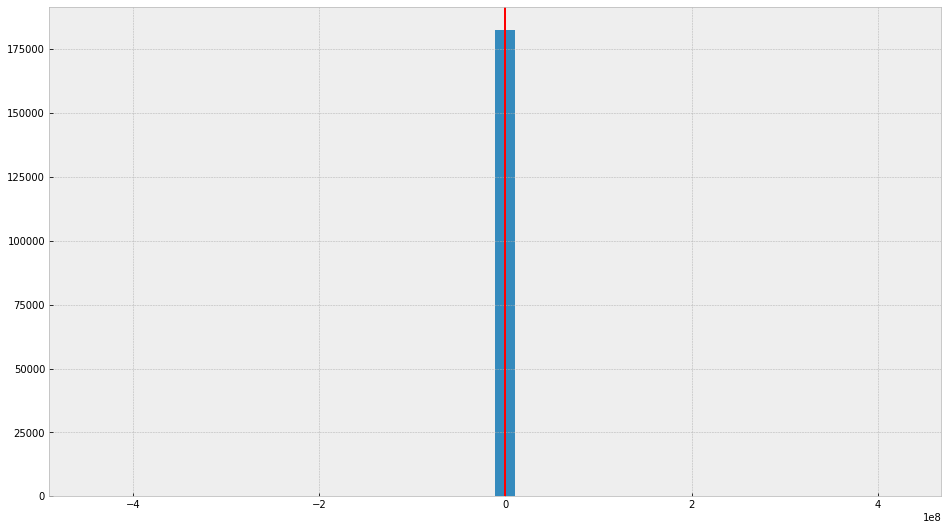

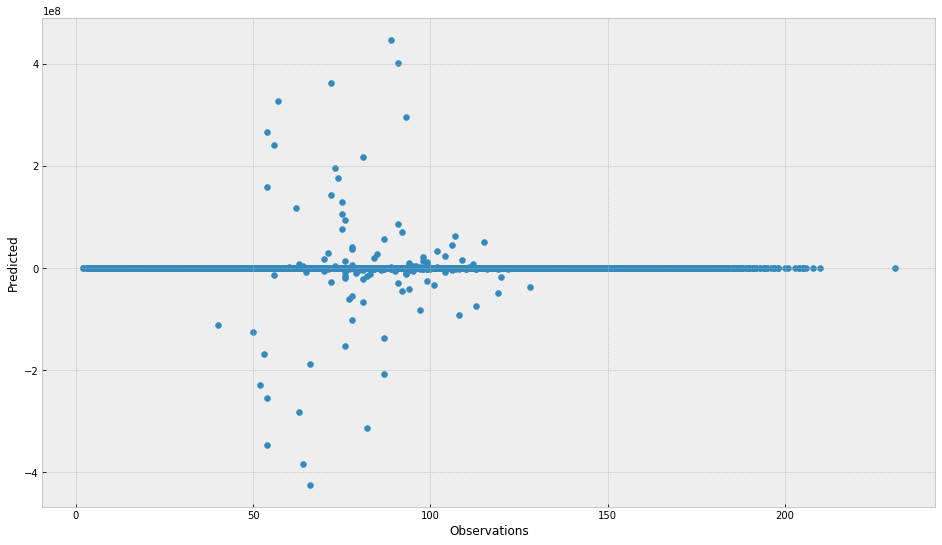

Best predicted time series: 


,store,item,rmse
304,7,5,3.836243
204,5,5,4.058547
254,6,5,4.173712
300,7,1,4.277267


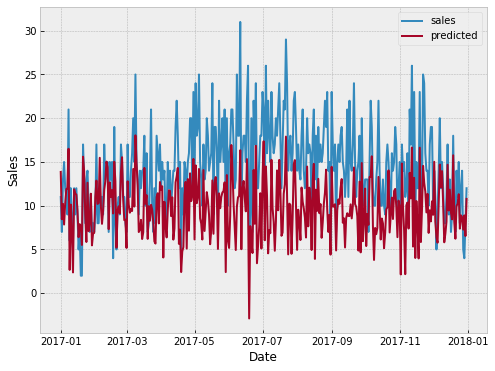

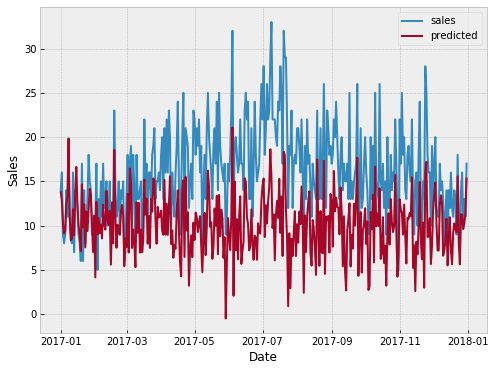

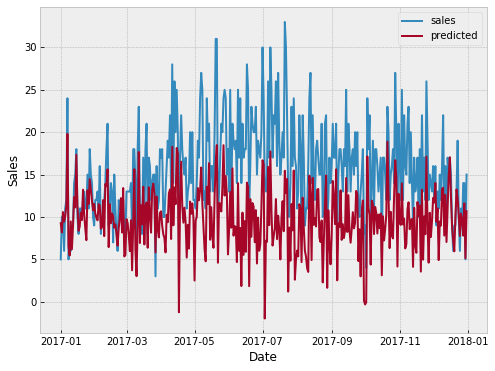

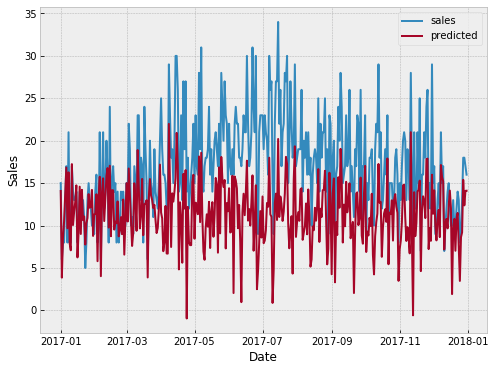

Worst predicted time series: 


,store,item,rmse
64,2,15,1.103045e+03
434,9,35,3.602904e+04
123,3,24,5.915902e+04
111,3,12,7.498118e+07


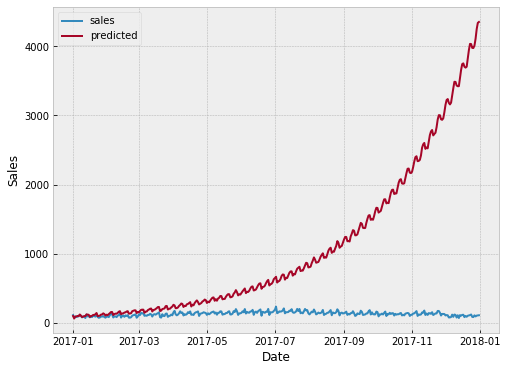

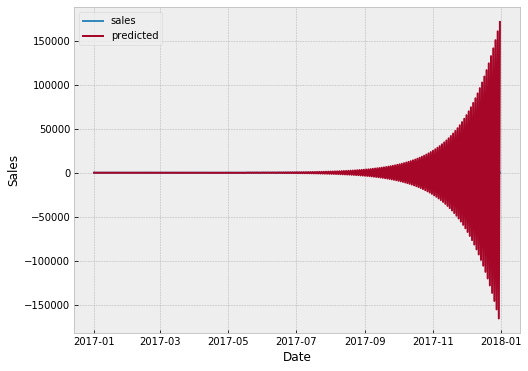

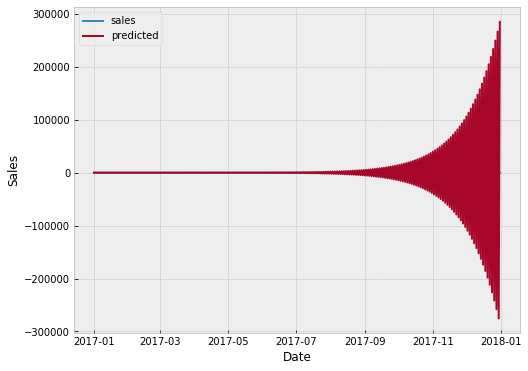

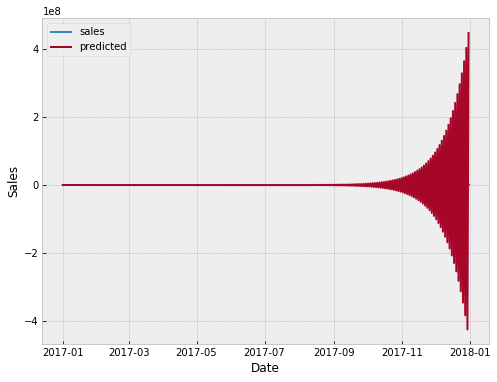

In [146]:
model_report(data, sar_result, model_name='Sarima')

# LightGBM (Gradient boosted trees) 

In [85]:
# Let's continue testing other models. A very strong candidate is LightGBM,an algorithm written
# by microsoft which was used to win many data science competitions on Kaggle.com 

def perform_lgb_forecast_on_series(series):
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = lgb.LGBMRegressor()
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = pd.Series(data=predictions,
                            index=y_test.index,
                            name='sales') # Convert to a pandas series
    return predictions

In [86]:
%%time
lgb_forecast = predict_all_series(data, perform_lgb_forecast_on_series)

Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-05,8,15,193,139.608550,53.391450,53.391450
2017-06-02,8,15,192,138.666541,53.333459,53.333459
2017-07-02,2,15,231,178.929159,52.070841,52.070841
2017-08-20,2,18,201,153.718880,47.281120,47.281120
2017-06-17,3,13,185,137.865513,47.134487,47.134487
2017-07-16,9,18,187,140.779371,46.220629,46.220629
2017-09-16,2,38,173,127.369043,45.630957,45.630957
2017-05-23,8,22,152,106.457146,45.542854,45.542854
2017-04-02,8,33,155,110.141604,44.858396,44.858396


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-01-30,2,12,49,48.999607,0.000393,0.000393
2017-04-23,4,37,41,41.000372,-0.000372,0.000372
2017-10-10,8,10,89,88.999652,0.000348,0.000348
2017-08-28,6,39,33,33.000327,-0.000327,0.000327
2017-04-13,5,31,50,49.999870,0.000130,0.000130
2017-02-09,5,39,24,23.999902,0.000098,0.000098
2017-10-08,1,20,52,52.000095,-0.000095,0.000095
2017-10-05,3,14,73,72.999906,0.000094,0.000094
2017-02-12,10,42,42,41.999967,0.000033,0.000033


The overall RMSE was 8.454766278224952
The mean error was 2.1905778823034887


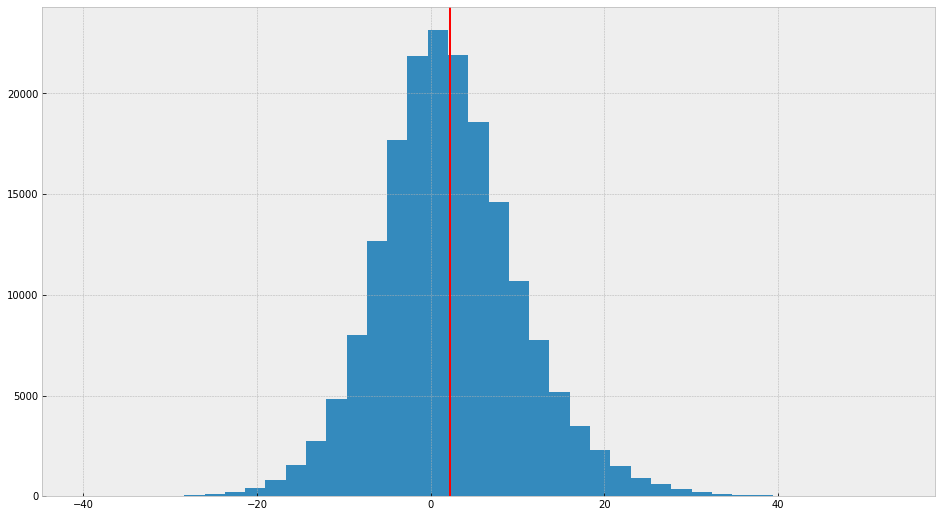

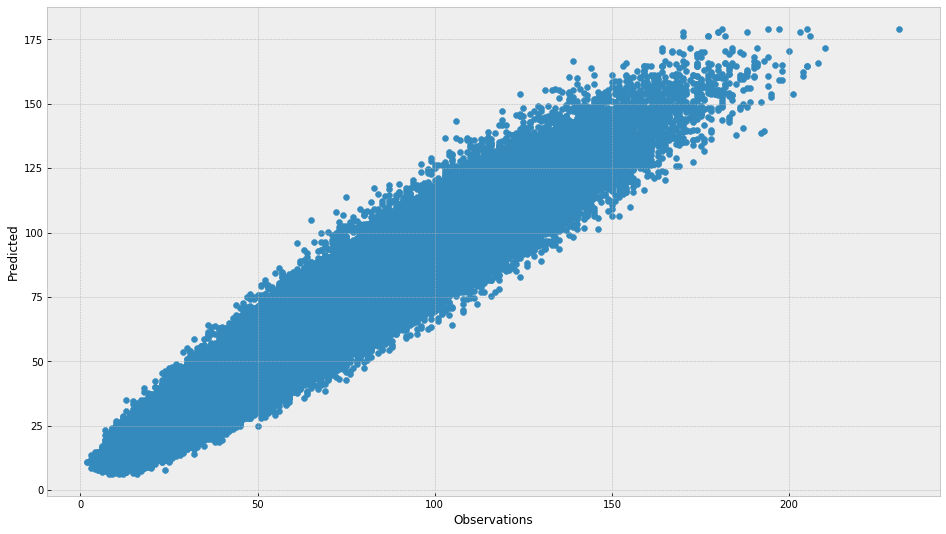

In [88]:
model_report(data, lgb_forecast, 'LightGBM')

# Deep Learning with PyTorch 

In [17]:
# Let's create a multi layer perceptron (MLP neural network) using PyTorch. PyTorch requires you to define a network as a class
# that inherits from the nn.Module class. We will create a neural network with two fully connected
# layers, and an output layer. We will also use ReLU activations functions for the neurons.

class MLPNet(nn.Module):  # Create a neural network, which inherits from the nn.Module
    
    def __init__(self, input_size, h1_neurons, h2_neurons):  # Here we define the network structure
        super(MLPNet, self).__init__()  # Initialize the nn.Module
        self.fc1 = nn.Linear(input_size, h1_neurons)  # First Layer
        self.fc2 = nn.Linear(h1_neurons, h2_neurons)  # Second Layer
        # Since the output is a single number, the output size is 1
        self.output_layer = nn.Linear(h2_neurons, 1)

    def forward(self, x):
        # Every class that inherits from nn.Module should have a forward function, which is
        # a list of operations to apply to the inputs in order to obtain the prediction
        x = F.relu(self.fc1(x))  # We use the ReLU function to introduce non-linearities in our network
        # Note that also other functions like the sigmoid, tanh, or ELU can be used
        x = F.relu(self.fc2(x))
        x = F.relu(self.output_layer(x))
        return x

In [23]:
# Deep learning libraries usually convert data to Tensor objects. Without getting too much into the
# details, this is done to make it easier to work with GPUs (even if we don't use a GPU we're still
# required to use tensors)

# Since PyTorch doesn't accept pandas DataFrame, let's convert everything to numpy ces first,
# using the .values method, then we convert the numpy 
nn_data_X = preprocessed_series.drop('sales', axis=1).values
nn_data_X = torch.Tensor(nn_data_X)

# VERY IMPORTANT: normalize the inputs to speed up convergence
nn_data_X = (nn_data_X - nn_data_X.mean(dim=0)) / nn_data_X.var(dim=0) 

nn_data_y = preprocessed_series['sales'].values
nn_data_y = torch.Tensor(nn_data_y)

# PyTorch requires your output to have an extra dimension to be in the same shape as the regressors
# Using .view(-1, 1) we add an extra dimension
print(nn_data_y)
nn_data_y = nn_data_y.view(-1, 1)
print(nn_data_y)
print(type(nn_data_X))

tensor([ 9., 14., 11.,  ..., 15., 27., 23.])
tensor([[ 9.],
        [14.],
        [11.],
        ...,
        [15.],
        [27.],
        [23.]])
<class 'torch.Tensor'>


In [24]:
n_features = nn_data_X.shape[1]  # Check the number of regressor (18)

In [25]:
# Now the tricky part

# First we instantiate a neural network with 2 hidden layers of 8 and 4 neurons
net = MLPNet(input_size=n_features,
              h1_neurons=8, h2_neurons=4)
# Then we define an optimizer to train our neural network. In this case we're using Stochastic Gradient
# Descent as a simple example
optimizer = opt.SGD(net.parameters(), lr=0.01)
# Then we define a loss function that we want to minimize. In this case we use RMSE
criterion = nn.MSELoss()
epochs = 1000  # Number of training iterations

In [27]:
losses = np.zeros(epochs)  # Create an array where we keep track of the loss function
for i in range(epochs):
    optimizer.zero_grad()  # In each iteration we set the gradients to 0
    # For more info check https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

    predictions = net(nn_data_X)  # Get the predictions. Using net as a function just calls the
                                  # forward method of our MLPNet
    loss = criterion(predictions, nn_data_y)  # Calculate the loss
    loss.backward()  # Calculate the gradients of the loss function with respect to the net parameters
    optimizer.step()  # Update Network parameters
    losses[i] = loss.item()
    if i % 100 == 0:
        print(loss.item())

18.714826583862305
18.63974380493164
18.566879272460938
18.543210983276367
18.47014808654785
18.456501007080078
18.345643997192383
18.448123931884766
18.553218841552734
18.55344009399414


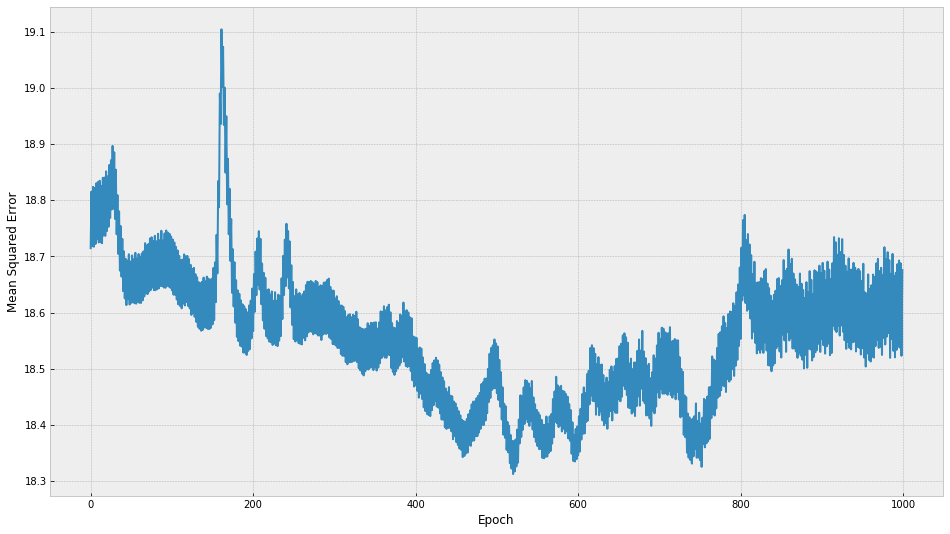

In [28]:
# Let's plot the loss function during training, to ensure the optimization was carried out successfully
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

In [284]:
# Now let's wrap everything into a function
def add_lags(series, lags=[7, 28, 365]):
    for lag in lags:
        series[f'lag_{lag}'] = series['sales'].shift(lag)
    series = series.dropna()
    return series

def perform_mlp_forecast_on_series(series, epochs=300, lr=0.01, h1_neurons=4, h2_neurons=2):
    series = preprocess_series(series)
    series = add_lags(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    # Save the dates before converting to tensor!
    dates = y_test.index
    
    # Convert to tensor
    X_train = torch.Tensor(X_train.values)
    X_test = torch.Tensor(X_test.values)
    # Also add a dimension to observations
    y_train = torch.Tensor(y_train.values).view(-1, 1)
    y_test = torch.Tensor(y_test.values).view(-1, 1)
    
    # Normalize
    input_mean = X_train.mean(dim=0)
    input_var = X_train.var(dim=0)
    
    X_train = (X_train - input_mean) / input_var
    X_test = (X_test - input_mean) / input_var # Note that we normalize test using the
                                               # mean and var of the training data
    
    # Instantiate network, optimizer, and loss function
    net = MLPNet(input_size=X_train.shape[1],
                 h1_neurons=h1_neurons, h2_neurons=h2_neurons)
    optimizer = opt.Adam(net.parameters(), lr=lr)  # This time let's use the Adam optimizer which is faster
    criterion = nn.MSELoss()
    
    # Training
    for i in range(epochs):
        optimizer.zero_grad()
        predictions = net(X_train) 
        loss = criterion(predictions, y_train) 
        loss.backward()
        optimizer.step()
    
    # Convert back to pandas series
    predictions = net(X_test)
    predictions = predictions.detach() # Detatch gradient or Pytorch will say it can't convert to numpy
    predictions = predictions.numpy().flatten()  # Convert to numpy array and flatten again
    predictions = pd.Series(data=predictions,
                        index=dates,
                        name='sales') # Convert to a pandas series
    return predictions

In [ ]:
%%time
mlp_forecast = predict_all_series(data, perform_mlp_forecast_on_series)

In [286]:
model_report(data, mlp_forecast, 'PyTorchNeuralNetwork')

NameError: name 'mlp_forecast' is not defined

# Multi Layer Perceptron (Neural Network)

In [287]:
def perform_neural_forecast_on_series(series):
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = MLPRegressor(hidden_layer_sizes=(100, ))
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = pd.Series(data=predictions,
                            index=y_test.index,
                            name='sales') # Convert to a pandas series
    return predictions

In [288]:
mlp_result = predict_all_series(data, perform_neural_forecast_on_series)

Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-02,2,15,231,117.667876,113.332124,113.332124
2017-07-09,2,13,210,112.142508,97.857492,97.857492
2017-07-16,9,28,195,97.615650,97.384350,97.384350
2017-07-16,9,18,187,94.832352,92.167648,92.167648
2017-07-05,8,15,193,101.971362,91.028638,91.028638
2017-07-09,2,15,205,117.667876,87.332124,87.332124
2017-07-21,2,15,198,113.714874,84.285126,84.285126
2017-07-01,8,28,204,119.790345,84.209655,84.209655
2017-07-30,2,22,191,107.061365,83.938635,83.938635


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-06-26,9,10,75,74.999352,6.476628e-04,6.476628e-04
2017-12-26,7,22,48,48.000592,-5.922539e-04,5.922539e-04
2017-03-21,2,40,33,33.000485,-4.847011e-04,4.847011e-04
2017-03-16,7,23,19,19.000438,-4.384783e-04,4.384783e-04
2017-11-14,5,29,51,51.000274,-2.741773e-04,2.741773e-04
2017-11-07,5,29,51,51.000274,-2.741773e-04,2.741773e-04
2017-12-28,9,10,56,55.999758,2.417781e-04,2.417781e-04
2017-02-26,7,19,24,24.000200,-1.995610e-04,1.995610e-04
2017-03-29,2,50,78,77.999958,4.239866e-05,4.239866e-05


The overall RMSE was 15.79038247842405
The mean error was 8.006658408513108


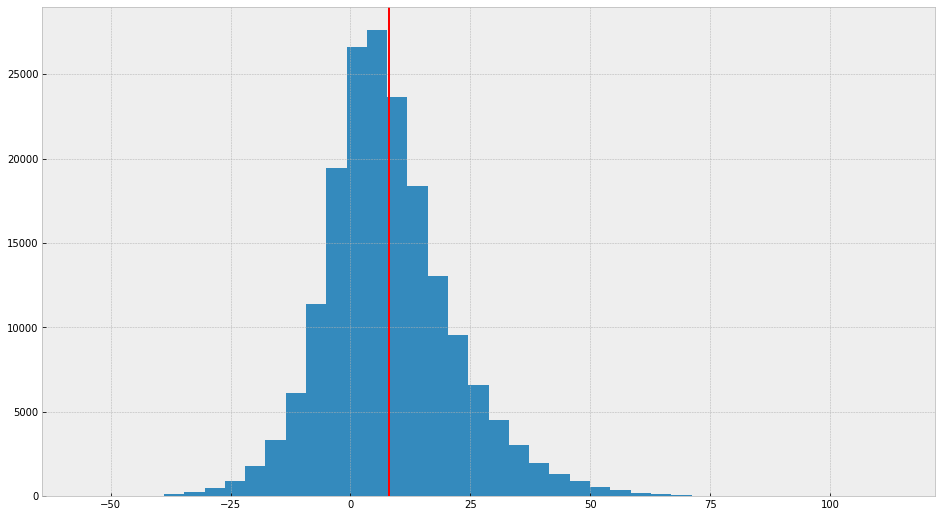

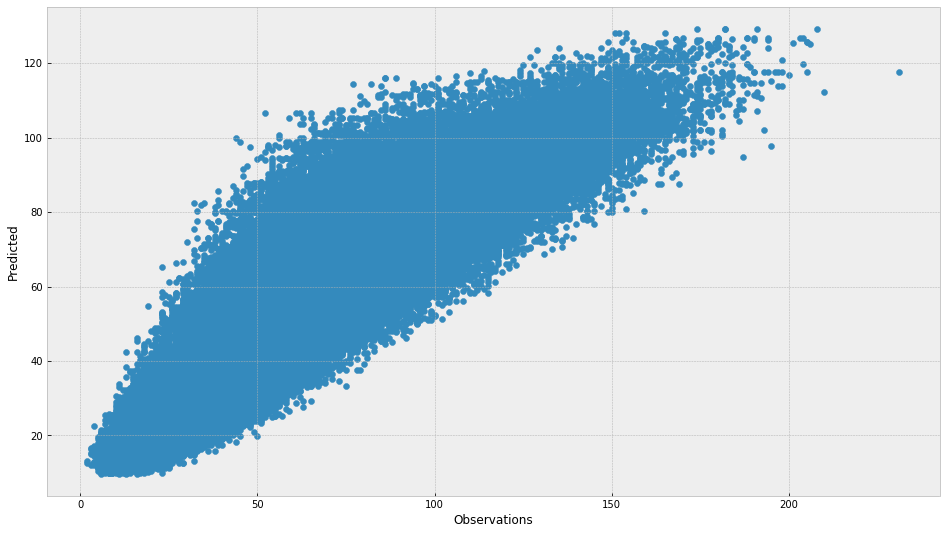

Best predicted time series: 


,store,item,rmse
250,6,1,4.346654
204,5,5,4.512980
304,7,5,4.611348
254,6,5,4.672453


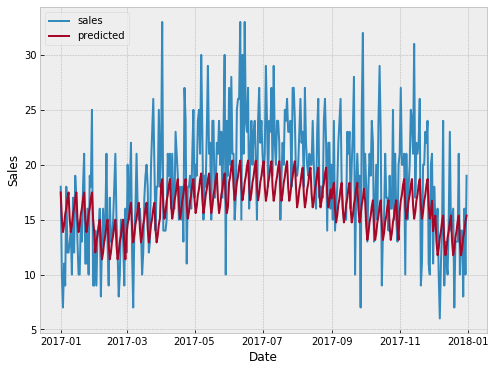

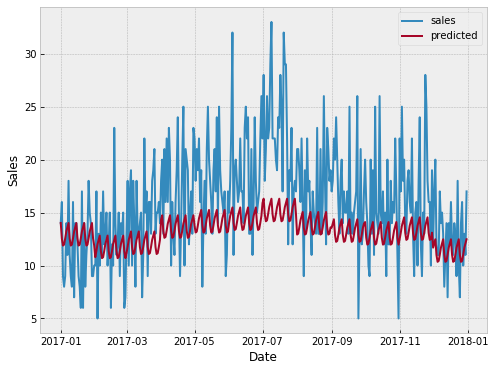

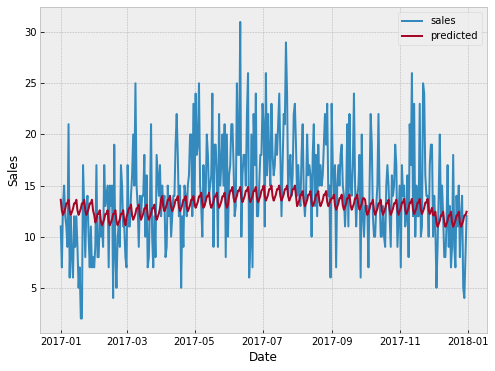

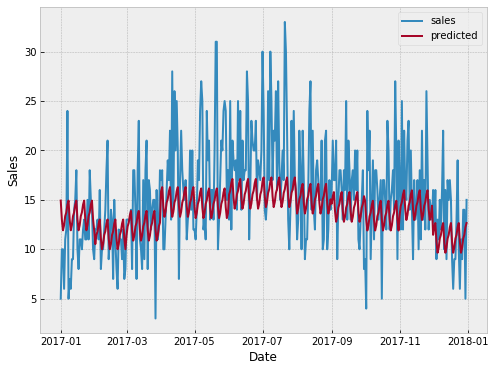

Worst predicted time series: 


,store,item,rmse
71,2,22,24.756271
64,2,15,24.999483
362,8,13,26.588238
62,2,13,27.132793


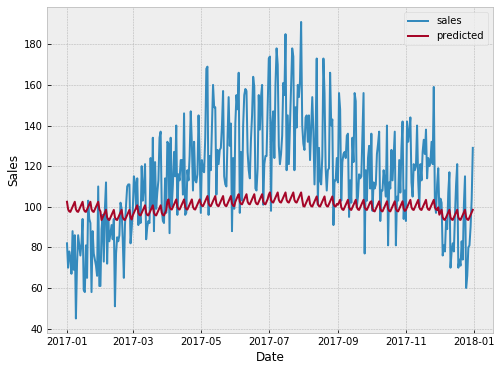

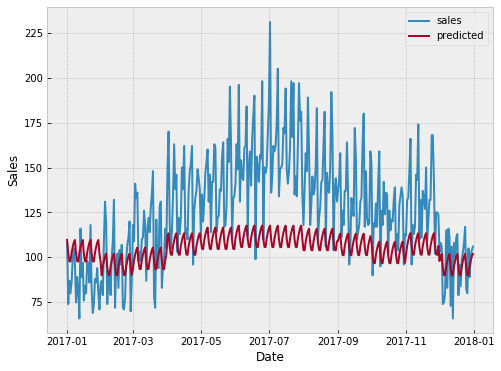

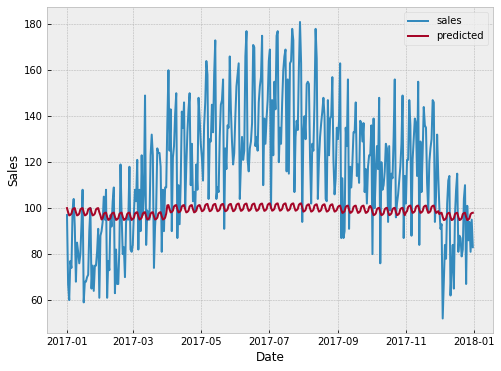

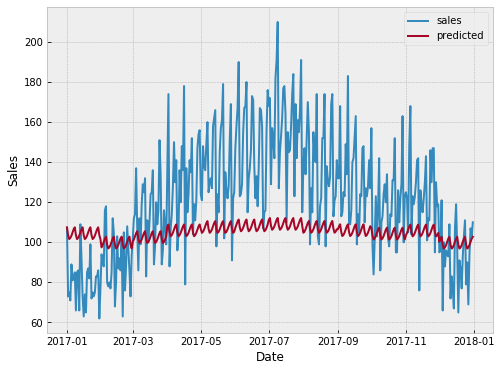

In [289]:
model_report(data, mlp_result, 'MLPNeuralNetwork')

# Ensemble model

In [280]:
# If you wish to discard some models in the ensemble forecast, list them in an array below
# We exclude Ensemble by default so you don't accidentally use the Ensemble result file
# to build the ensemble model itself
MODELS_TO_EXCLUDE = ['Sarima', 'Ensemble']


# Check all available result files
files = os.listdir('Results')
files = [file for file in files if not any(string in file for string in MODELS_TO_EXCLUDE)]
model_names = [x.split('.')[0] for x in files]
print('Ensemble predictions based on: ', model_names)
# Read all files
results = [pd.read_csv('Results/' + file_name) for file_name in files]
# Add a column to each dataset that says which model made the prediction
for model_name, dataset in zip(model_names, results):
    dataset['model'] = model_name
# Concatenate all result dataframes in a single dataframe
results = pd.concat(results)
# Convert date and set it as index
results['date'] = pd.to_datetime(results['date'])
results = results.set_index('date')
# Pivot the dataframe to have all models on different columns
results = results.pivot_table(index=['date', 'store', 'item', 'sales'],
                              columns=['model'],
                              values=['predicted'])

ensemble_predictions = results.mean(axis=1)
results = results.reset_index('sales')

ensemble_results = pd.DataFrame(data={'predicted': ensemble_predictions.values},
                                index=results.index)

Ensemble predictions based on:  ['LightGBM', 'Linear_Regression', 'MLPNeuralNetwork', 'RandomForest']


Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-02,2,15,231,160.909641,70.090359,70.090359
2017-08-20,2,18,201,135.674786,65.325214,65.325214
2017-07-05,8,15,193,128.588547,64.411453,64.411453
2017-06-02,8,15,192,128.664005,63.335995,63.335995
2017-07-16,9,18,187,123.696430,63.303570,63.303570
2017-07-16,9,28,195,134.435342,60.564658,60.564658
2017-07-08,2,18,204,143.859353,60.140647,60.140647
2017-06-17,3,13,185,124.981161,60.018839,60.018839
2017-07-01,8,28,204,145.729596,58.270404,58.270404


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-05-10,8,19,53,52.999304,0.000696,0.000696
2017-12-20,8,17,32,31.999315,0.000685,0.000685
2017-12-18,9,40,21,20.999318,0.000682,0.000682
2017-01-29,8,24,75,74.999366,0.000634,0.000634
2017-08-03,1,47,24,24.000565,-0.000565,0.000565
2017-03-04,6,1,18,17.999631,0.000369,0.000369
2017-08-04,6,26,42,41.999690,0.000310,0.000310
2017-06-29,3,5,24,24.000264,-0.000264,0.000264
2017-08-07,7,17,23,22.999810,0.000190,0.000190


The overall RMSE was 10.593214957894737
The mean error was 5.176099343148093


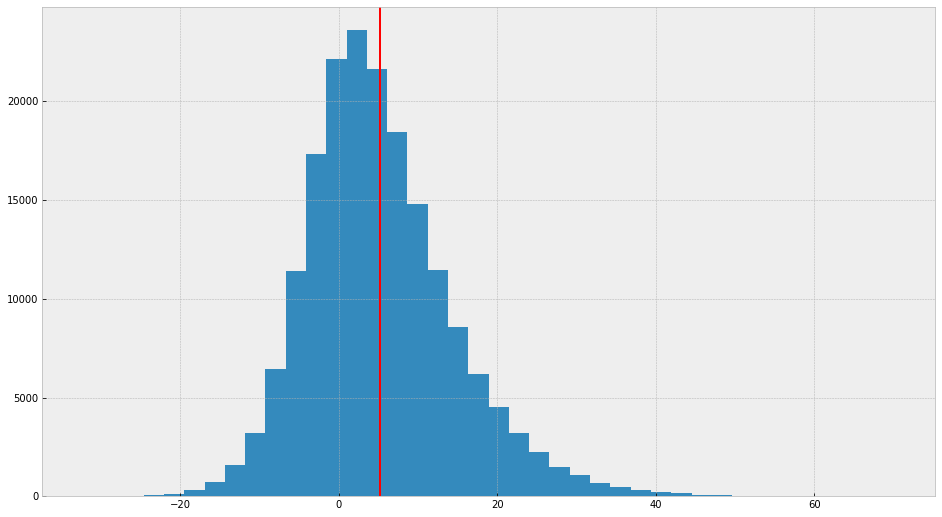

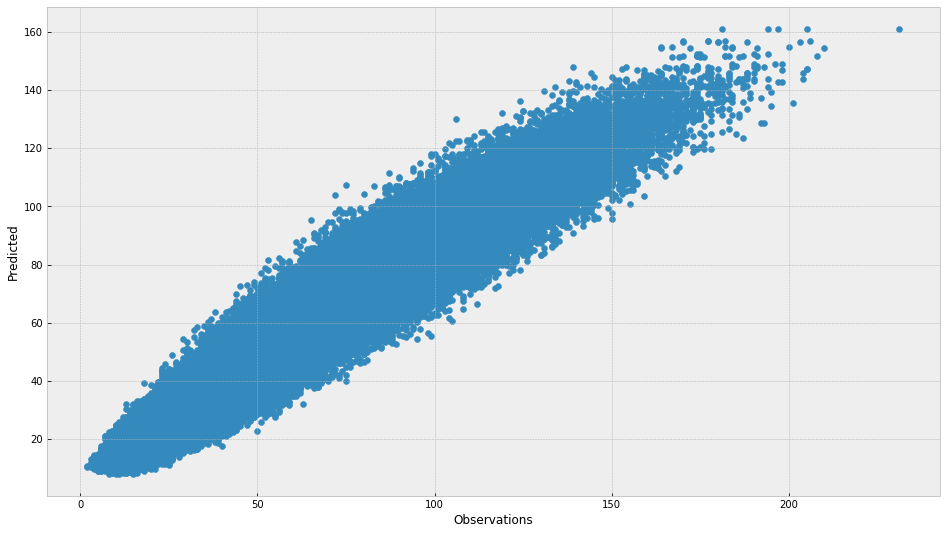

Best predicted time series: 


,store,item,rmse
250,6,1,3.978255
204,5,5,4.039796
304,7,5,4.219982
303,7,4,4.269926


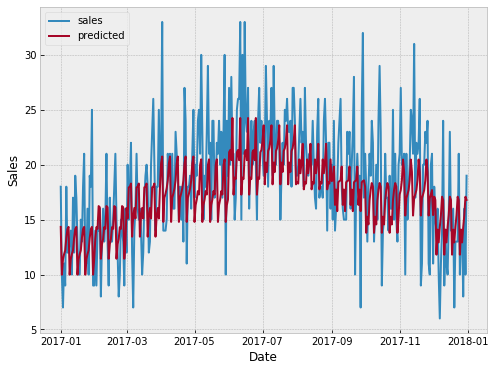

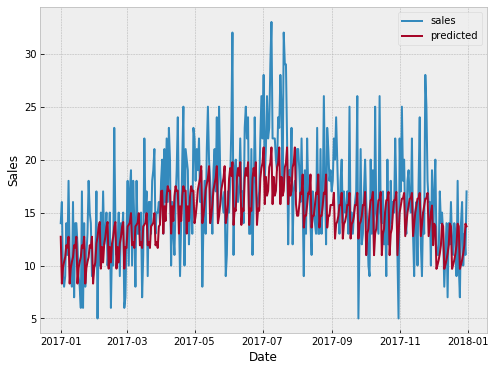

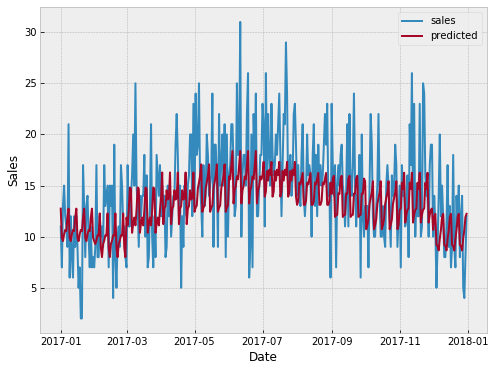

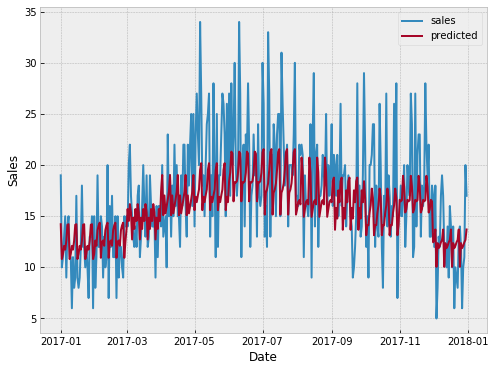

Worst predicted time series: 


,store,item,rmse
62,2,13,14.396612
364,8,15,14.511254
77,2,28,14.696068
67,2,18,15.278504


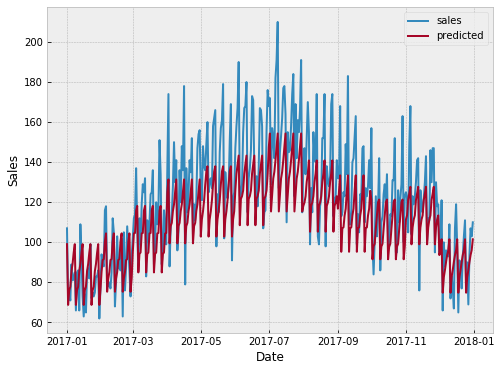

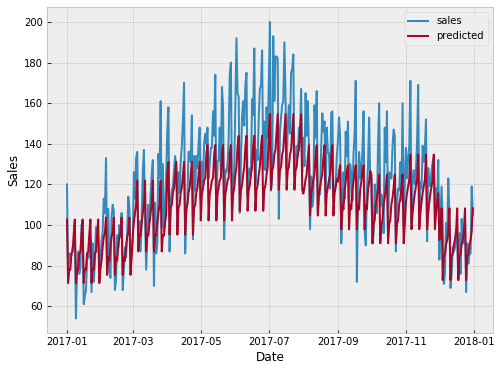

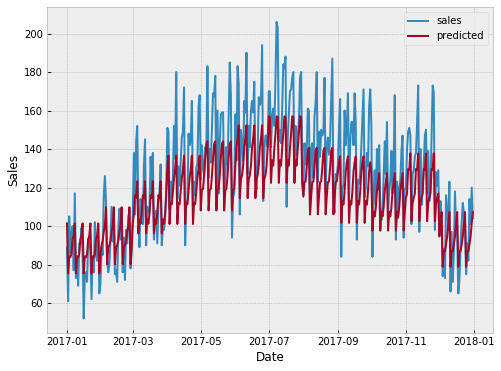

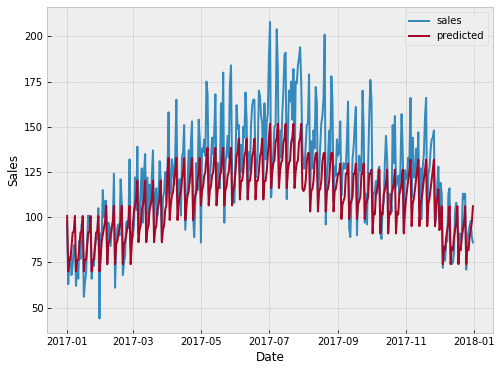

In [281]:
model_report(data, ensemble_results, 'Ensemble')